In [1]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import keras
import numpy as np
from keras.layers import Dropout
import matplotlib.pyplot as plt

def split_dataset(data, dias, lim_treino):
    train, test = data[:lim_treino], data[lim_treino:]
    train = array(split(train, len(train)/dias))
    test = array(split(test, len(test)/dias))
    return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1 #movimento pra criacao de outputs
    return array(X), array(y)

def build_model(train, n_input, dias):
    train_x, train_y = to_supervised(train, n_input, dias)
    
    verbose, epochs, batch_size = 1, 30, 8
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(LSTM(64, activation='relu',return_sequences=False))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(Dropout(0.8))
    model.add(TimeDistributed(Dense(1)))
    otimizador = keras.optimizers.RMSprop(lr=0.003, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mae', optimizer=otimizador)
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False,
              validation_split = 0.01)
    model.save('resultado.h5')
    return model

# make a forecast
def forecast(model, history, n_input):
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2])) #
    input_x = data[-n_input:, :] #ultimas informacoes pra entrada
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

/Users/Anderson/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# evaluate a single model
def predizer(train, test, n_input, dias, model):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    return array(predictions)

#### Analise de previsao de 5 dias

In [3]:
dias = 5
n_input = 20
amostras = 2800
lim_treino = amostras - dias

In [4]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/preprocessed.csv')

In [5]:
df = df.iloc[:amostras]

In [6]:
train, test = split_dataset(df.values, dias, lim_treino)

In [7]:
model = build_model(train, n_input, dias)

Train on 2742 samples, validate on 28 samples
Epoch 1/30
2742/2742 [==============================] - 19s 7ms/step - loss: 177.0594 - val_loss: 0.3002
Epoch 2/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1989 - val_loss: 0.5129
Epoch 3/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1770 - val_loss: 0.3925
Epoch 4/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1463 - val_loss: 0.3563
Epoch 5/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1502 - val_loss: 0.2680
Epoch 6/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1613 - val_loss: 0.2233
Epoch 7/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1711 - val_loss: 0.3133
Epoch 8/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1594 - val_loss: 0.3813
Epoch 9/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1446 - val_loss: 0.3466
Epoch 10/30
2742/2742 [==

In [8]:
pred = predizer(train, test, n_input, dias, model)

In [9]:
train.shape

(559, 5, 11)

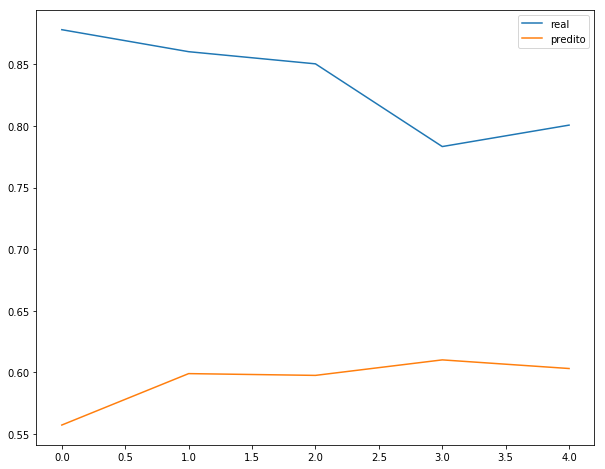

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,0].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [11]:
pred = predizer(train, train, n_input, dias, model)

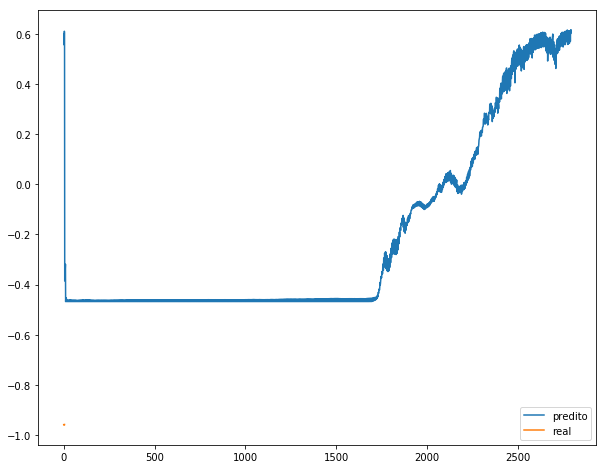

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
plt.plot(train[0,:,0].flatten(), label = 'real')
plt.legend()
plt.show()

#### NOV,EQIX,CTAS,CRM,BSX,IT,V,MSI,CLX,WAT

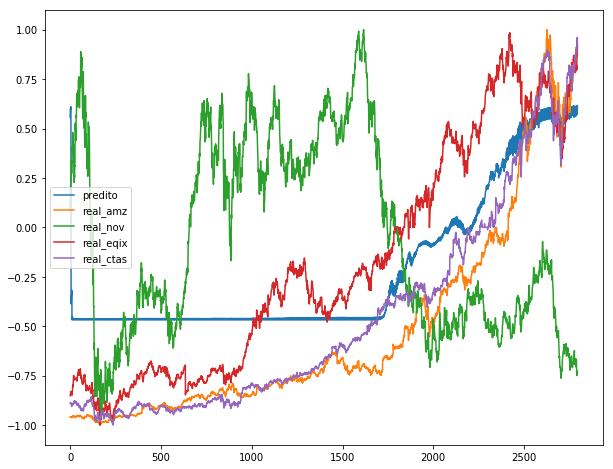

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
plt.plot(train[:,:,0].flatten(), label = 'real_amz')
plt.plot(train[:,:,1].flatten(), label = 'real_nov')
plt.plot(train[:,:,2].flatten(), label = 'real_eqix')
plt.plot(train[:,:,3].flatten(), label = 'real_ctas')
plt.legend()
plt.show()

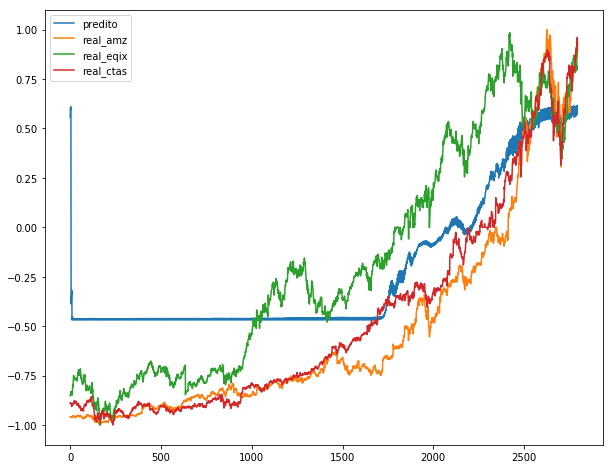

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
plt.plot(train[:,:,0].flatten(), label = 'real_amz')
plt.plot(train[:,:,2].flatten(), label = 'real_eqix')
plt.plot(train[:,:,3].flatten(), label = 'real_ctas')
plt.legend()
plt.show()

#### Removendo NOV

In [16]:
df.drop(labels = 'NOV', axis = 1, inplace = True)

In [17]:
train, test = split_dataset(df.values, dias, lim_treino)

In [18]:
model = build_model(train, n_input, dias)

Train on 2742 samples, validate on 28 samples
Epoch 1/30
2742/2742 [==============================] - 22s 8ms/step - loss: 26.6830 - val_loss: 0.3263
Epoch 2/30
2742/2742 [==============================] - 15s 6ms/step - loss: 2.6080 - val_loss: 0.1836
Epoch 3/30
2742/2742 [==============================] - 15s 6ms/step - loss: 0.1905 - val_loss: 0.3479
Epoch 4/30
2742/2742 [==============================] - 15s 6ms/step - loss: 0.1504 - val_loss: 0.3723
Epoch 5/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1508 - val_loss: 0.2372
Epoch 6/30
2742/2742 [==============================] - 15s 6ms/step - loss: 0.1524 - val_loss: 0.3325
Epoch 7/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1372 - val_loss: 0.3404
Epoch 8/30
2742/2742 [==============================] - 15s 6ms/step - loss: 0.1436 - val_loss: 0.3379
Epoch 9/30
2742/2742 [==============================] - 15s 6ms/step - loss: 0.1473 - val_loss: 0.4189
Epoch 10/30
2742/2742 [===

In [19]:
pred = predizer(train, test, n_input, dias, model)

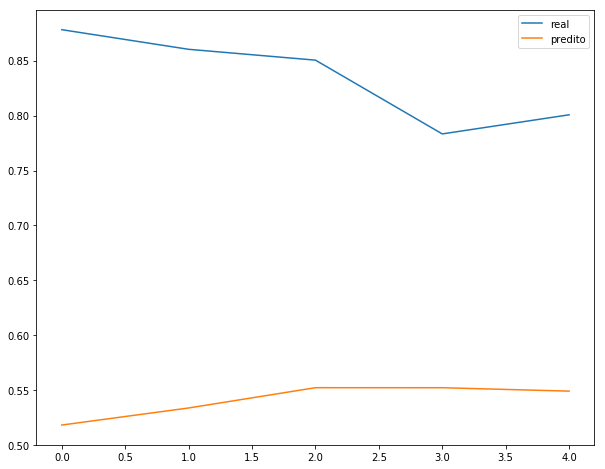

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,0].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [21]:
pred = predizer(train, train, n_input, dias, model)

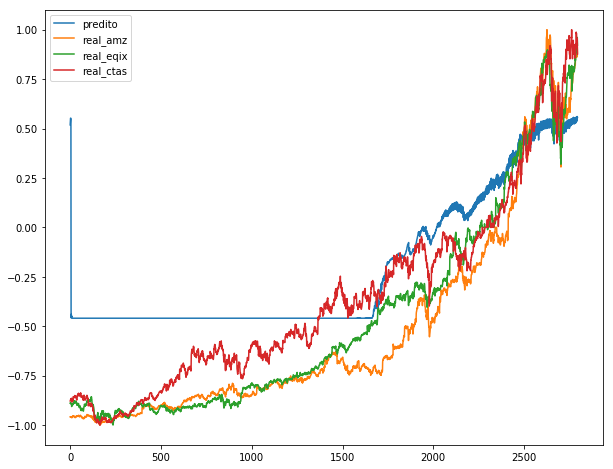

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
plt.plot(train[:,:,0].flatten(), label = 'real_amz')
plt.plot(train[:,:,2].flatten(), label = 'real_eqix')
plt.plot(train[:,:,3].flatten(), label = 'real_ctas')
plt.legend()
plt.show()

#### Usando somente 3

In [23]:
df = df[['AMZN', 'EQIX', 'CTAS']]

In [24]:
train, test = split_dataset(df.values, dias, lim_treino)

In [25]:
model = build_model(train, n_input, dias)

Train on 2742 samples, validate on 28 samples
Epoch 1/30
2742/2742 [==============================] - 19s 7ms/step - loss: 0.2162 - val_loss: 0.3745
Epoch 2/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1921 - val_loss: 0.4832
Epoch 3/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.3614 - val_loss: 0.1534
Epoch 4/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1493 - val_loss: 0.0971
Epoch 5/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1469 - val_loss: 0.1470
Epoch 6/30
2742/2742 [==============================] - 16s 6ms/step - loss: 0.1481 - val_loss: 0.1594
Epoch 7/30
2742/2742 [==============================] - 17s 6ms/step - loss: 0.1325 - val_loss: 0.2218
Epoch 8/30
2742/2742 [==============================] - 18s 7ms/step - loss: 0.1652 - val_loss: 0.4971
Epoch 9/30
2742/2742 [==============================] - 18s 6ms/step - loss: 0.2270 - val_loss: 0.4260
Epoch 10/30
2742/2742 [====

In [26]:
pred = predizer(train, test, n_input, dias, model)

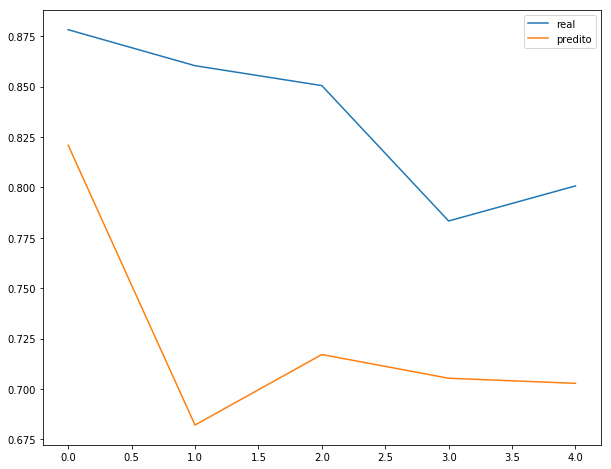

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,0].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [28]:
pred = predizer(train, train, n_input, dias, model)

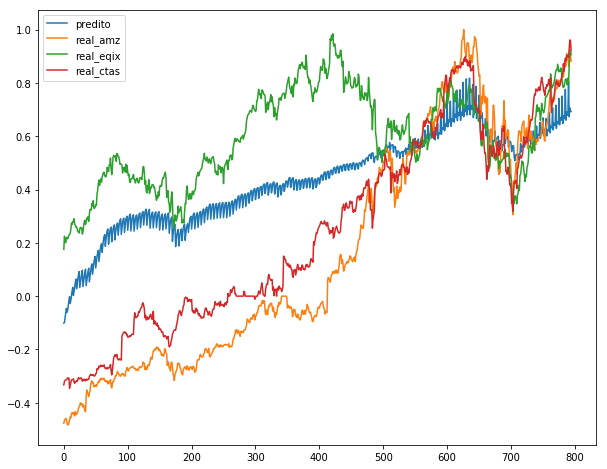

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten()[2000:], label = 'predito')
plt.plot(train[:,:,0].flatten()[2000:], label = 'real_amz')
plt.plot(train[:,:,1].flatten()[2000:], label = 'real_eqix')
plt.plot(train[:,:,2].flatten()[2000:], label = 'real_ctas')
plt.legend()
plt.show()

#### Prevendo 10 dias

In [45]:
dias = 10
n_input = 60
amostras = 2800
lim_treino = amostras - dias

In [48]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/preprocessed.csv')
df = df.iloc[:amostras]

In [49]:
train, test = split_dataset(df.values, dias, lim_treino)

In [50]:
model = build_model(train, n_input, dias)

Train on 2692 samples, validate on 28 samples
Epoch 1/30
2692/2692 [==============================] - 48s 18ms/step - loss: 1006534575.1651 - val_loss: 0.3038
Epoch 2/30
2692/2692 [==============================] - 44s 16ms/step - loss: 0.5398 - val_loss: 0.2318
Epoch 3/30
2692/2692 [==============================] - 43s 16ms/step - loss: 0.1915 - val_loss: 0.2746
Epoch 4/30
2692/2692 [==============================] - 43s 16ms/step - loss: 0.1486 - val_loss: 0.3749
Epoch 5/30
2692/2692 [==============================] - 44s 16ms/step - loss: 156570.5867 - val_loss: 0.2591
Epoch 6/30
2692/2692 [==============================] - 43s 16ms/step - loss: 33007728.0312 - val_loss: 0.3444
Epoch 7/30
2692/2692 [==============================] - 44s 16ms/step - loss: 0.2982 - val_loss: 0.4451
Epoch 8/30
2692/2692 [==============================] - 44s 16ms/step - loss: 26.0154 - val_loss: 0.3566
Epoch 9/30
2692/2692 [==============================] - 43s 16ms/step - loss: 0.2531 - val_loss: 0.1

In [51]:
pred = predizer(train, train, n_input, dias, model)

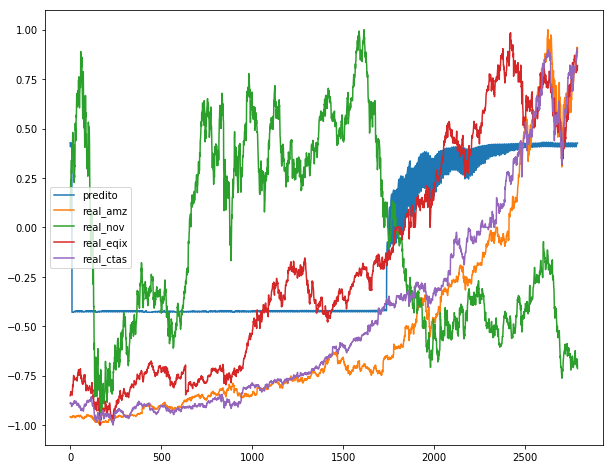

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
plt.plot(train[:,:,0].flatten(), label = 'real_amz')
plt.plot(train[:,:,1].flatten(), label = 'real_nov')
plt.plot(train[:,:,2].flatten(), label = 'real_eqix')
plt.plot(train[:,:,3].flatten(), label = 'real_ctas')
plt.legend()
plt.show()

In [53]:
pred = predizer(train, test, n_input, dias, model)

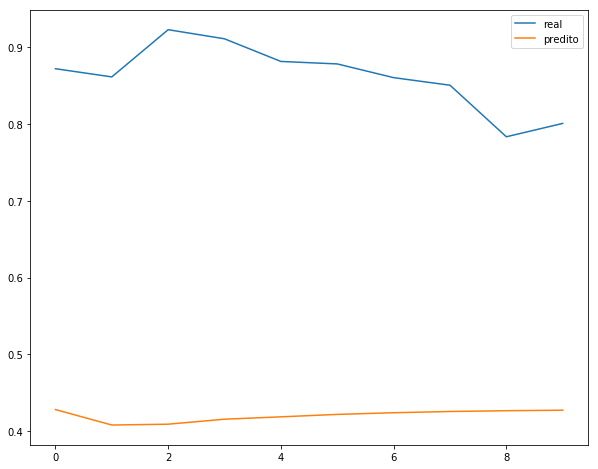

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,0].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()